In [168]:
!sudo apt-get update
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install pyglet
!pip install imageio-ffmpeg

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Looking in indexes: https://pypi.org/simple, https:

In [1]:

import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import base64
import imageio
import IPython
import PIL.Image
import pyvirtualdisplay
import matplotlib.patches as patches
from collections import defaultdict
from moviepy.video.io.bindings import mplfig_to_npimage

import gym
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'imageio'

: 

In [170]:
# Configuration parameters for the whole setup
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
# env = gym.make("CartPole-v0")  # Create the environment
# env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [171]:
class enviornment:
  def __init__(self):
    print('initialize env')
    self.grid= np.zeros((21, 21))
    self.total_user_distribution=self.users_generator()
    self.state=self.reset() #for q1 
    


  def users_generator(self):
    self.total_user_distribution=[]
    for i in [[17,4,5,40],[12,6,4,15],[6,15,4,15],[15,15,5,20],[7,16,3,20]]:
      
      x,y,std,num=i[0],i[1],i[2],i[3]
      X=np.abs(np.random.normal(x,std,num))  #by using abs all the users with -ve will be refelcted 
      Y=np.abs(np.random.normal(y,std,num))
      user_distribution=[]

      #refelect back the users during distribution  
      for k, (i,j) in enumerate(zip(X,Y),):
        if i >20:
          X[k]=20-(i-20)
        if j>20:
          Y[k]=40-j 

      #ignore users thare are in the landing and no fly zone  
      for i,j in zip(X,Y):
        if i>=7 and i<= 9 and j>=18 :
          continue
        if i>=8 and i<= 14 and j>=10 and j<=13 :
          continue
        user_distribution.append((i,j))
      self.total_user_distribution.append(user_distribution)
    
    return self.total_user_distribution
  
  #creat image
  def render(self,Title="",state=(0,0),optimal_path=[],path_plot=False):
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"]=(10,9)
    ax.imshow(self.grid, cmap='Greys',origin='lower')
    rect = patches.Rectangle((7, 18), 2, 2, linewidth=2, edgecolor='black', facecolor='green')
    ax.add_patch(rect) 
    rect = patches.Rectangle((8, 10), 6, 3, linewidth=2, edgecolor='black', facecolor='red')
    ax.add_patch(rect)
    rect = patches.Rectangle((4, -0.5), 6, 1, linewidth=2, edgecolor='black', facecolor='blue')
    ax.add_patch(rect) 
    rect = patches.Rectangle((12, -0.5), 3, 1, linewidth=2, edgecolor='black', facecolor='blue')
    ax.add_patch(rect)

    plt.text(4.5, 0, "↟↟↟↟↟↟↟↟↟↟↟", color='white', fontsize=14)
    plt.text(12.5, 0, "↟↟↟↟↟", color='white', fontsize=14)

    plt.text(9.5, 11.2, "No Fly Zone", color='Black', fontsize=14)
    plt.text(7.7, 18.7, "SL", color='Black', fontsize=14)
    plt.xticks(np.arange(0, 21, 1),np.arange(0, 21, 1))
    plt.yticks(np.arange(0, 21, 1),np.arange(0, 21, 1))
    plt.title(Title)
    plt.grid()


    for t,symbol in zip(self.total_user_distribution,['x','o','*','#','+']):
        for i in t:
          plt.text(i[0], i[1], symbol, color='Black', fontsize=11)

    rect = patches.Rectangle((state[0]-1.5, state[1]-1.5), 3, 3, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    if path_plot:
      for state, next_state in optimal_path:
        plt.arrow(state[0],state[1],0.9*(next_state[0]-state[0]), 0.9*(next_state[1]-state[1]),head_width=0.1, color='Red',width=0.01)

    #plt.show()
    plt.close()
    return fig
  
  

  def is_outoff_grid(self,i, j):
      if i < 0 or i > 20 or j < 0 or j > 20:
          return True
      elif i>=8 and i<= 14 and j>=10 and j<=13 :
          return True
      else:
          return False

  def surveillance(self,total_user_distribution,xnow,ynow,xnext,ynext,history):
  
    coverd_users_now=[]
    coverd_users_next=[]
    if (xnow,ynow) not in history:
        
        xmax=xnow+1.5
        xmin=xnow-1.5
        ymax=ynow+1.5
        ymin=ynow-1.5
        for t in self.total_user_distribution:
          for i in t:
            
            if i[0]<=xmax and i[0]>=xmin and i[1]<=ymax and i[1]>=ymin:
              coverd_users_now.append((i[0],i[1]))
    
    if (xnext,ynext) not in history:
        
        xmax=xnext+1.5
        xmin=xnext-1.5
        ymax=ynext+1.5
        ymin=ynext-1.5
        for t in self.total_user_distribution:
          for i in t:
            
            if i[0]<=xmax and i[0]>=xmin and i[1]<=ymax and i[1]>=ymin:
              coverd_users_next.append((i[0],i[1]))
              
              #print(i[0],i[1])
    return len(list(set(coverd_users_next) - set(coverd_users_now)))  #when overlap only count the new people found


  def step(self,state, action):
        
        self.battery+=-1
        captured_ppl=0
        # take one step
        i, j = state[0]+3*action[0], state[1]+3*action[1]

        #check if the state is affected by wind 4<x<10 or 12<x<15
        if 4<=state[0]<=10  or 12<=state[0]<=15:
             i, j = state[0]+3*action[0], state[1]+3*action[1]+1  #shift 1 meter upward


        # check if the next state is out off grid
        if self.is_outoff_grid(i, j):
            
            #if it is in no fly zone  it will take its to  previous state
            if i>=8 and i<= 14 and j>=10 and j<=13 :
              i, j = state[0], state[1]
            else :
              i, j=np.abs(i), np.abs(j)   # if it is out of grid it will be refelcted
              if i >20:
                i=40-i
              if j>20:
                j=40-j

          
            
            
            reward=-5
            if self.battery==0:
              self.Done=True 
            self.state=(i,j)
            return (i,j), reward,self.Done,captured_ppl

        if i >=7 and i <= 9 and j>=18 and j<=20 :
            reward = 20
            self.Done=True
            
            self.state=(i,j)
            return (i,j), reward,self.Done,captured_ppl
        else:
            captured_ppl=self.surveillance(self.total_user_distribution,state[0],state[1],i,j,self.history)  #current state and next state will be consdiered
            reward =captured_ppl-1
            if (i,j) in self.history:
              reward=-10
            if self.battery==0:
              self.Done=True 
        self.state=(i,j)
        return (i,j), reward,self.Done,captured_ppl

  def reset(self):
    #self.state=(0,0) #q1
    Xint=np.random.choice([0, 1, 2])  #intial randomly selected [0,2]
    Yint=np.random.choice([0, 1, 2])

    self.state=(Xint,Yint)  #for Q2,Q3,Q4
    self.battery=25
    self.Done=False
    self.history=[]
    
    return self.state 

In [172]:
  
#video maker
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [173]:
env =enviornment()

initialize env


In [174]:
num_inputs = 2
num_actions = 4
num_hidden = 128

##Actor_Critic 

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

In [175]:
video=imageio.get_writer("Actor-Critic.mp4", fps=3)
actions=([(0, 1), (0,-1), (-1,0), (1,0)])
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0
episodes=1000

store_captured_ppl=[]
for i in range(episodes):  # Run episodes
      env =enviornment()   # location is redrown
      print("Episode",i)
      state = env.reset()
      episode_reward = 0
      total_captured_ppl=0
      optimal_path = []
      done=False

      with tf.GradientTape() as tape:
          
          while not done:
              # env.render(); Adding this line would show the attempts
              # of the agent in a pop up window.

              state_m = tf.convert_to_tensor(state)  #state modified used for model
              state_m = tf.expand_dims(state, 0)

              # Predict action probabilities and estimated future rewards
              # from environment state
              action_probs, critic_value = model(state_m)
              critic_value_history.append(critic_value[0, 0])
              
              #print(action_probs,critic_value)

              # Sample action from action probability distribution
              action = np.random.choice(num_actions, p=np.squeeze(action_probs))  #index
              action_probs_history.append(tf.math.log(action_probs[0, action]))   #action index store
              
              action=actions[action]
              

              # Apply the sampled action in our environment
              next_state, reward, done, captured_ppl = env.step(state, action)
              if next_state not in env.history:
                env.history.append(next_state)
              total_captured_ppl+=captured_ppl
              
              # state, reward, done, _ = env.step(action)
              rewards_history.append(reward)
              episode_reward += reward

              print('state', state, 'action', action,'next_state', next_state, 'reward',reward,'battery',env.battery,'Done',done)
              optimal_path.append([state, next_state])

              if (i+1)%25==0:  # creat video from the last episode
                x=env.render("Episdoe %d"%i, state)
                numpy_fig = mplfig_to_npimage(x)
                video.append_data(numpy_fig)

              state=next_state

          store_captured_ppl.append(total_captured_ppl) 
          print("total captured people",total_captured_ppl  )
          if (i+1)%25==0:
            x=env.render("Episdoe %d , People found= %d "%(i,total_captured_ppl), state)
            numpy_fig = mplfig_to_npimage(x)
            video.append_data(numpy_fig)

          # Update running reward to check condition for solving
          running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

          # Calculate expected value from rewards
          # - At each timestep what was the total reward received after that timestep
          # - Rewards in the past are discounted by multiplying them with gamma
          # - These are the labels for our critic
          returns = []
          discounted_sum = 0
          for r in rewards_history[::-1]:
              discounted_sum = r + gamma * discounted_sum
              returns.insert(0, discounted_sum)

          # Normalize
          returns = np.array(returns)
          returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
          returns = returns.tolist()

          # Calculating loss values to update our network
          history = zip(action_probs_history, critic_value_history, returns)
          actor_losses = []
          critic_losses = []
          for log_prob, value, ret in history:
              # At this point in history, the critic estimated that we would get a
              # total reward = `value` in the future. We took an action with log probability
              # of `log_prob` and ended up recieving a total reward = `ret`.
              # The actor must be updated so that it predicts an action that leads to
              # high rewards (compared to critic's estimate) with high probability.
              diff = ret - value
              actor_losses.append(-log_prob * diff)  # actor loss

              # The critic must be updated so that it predicts a better estimate of
              # the future rewards.
              critic_losses.append(
                  huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
              )

          # Backpropagation
          loss_value = sum(actor_losses) + sum(critic_losses)
          grads = tape.gradient(loss_value, model.trainable_variables)
          optimizer.apply_gradients(zip(grads, model.trainable_variables))

          # Clear the loss and reward history
          action_probs_history.clear()
          critic_value_history.clear()
          rewards_history.clear()

      # Log details
      episode_count += 1
      if episode_count % 10 == 0:
          template = "running reward: {:.2f} at episode {}"
          print(template.format(running_reward, episode_count))

video.close()
embed_mp4("Actor-Critic.mp4")    

initialize env
Episode 0
state (2, 2) action (-1, 0) next_state (1, 2) reward -5 battery 24 Done False
state (1, 2) action (-1, 0) next_state (2, 2) reward -5 battery 23 Done False
state (2, 2) action (1, 0) next_state (5, 2) reward -1 battery 22 Done False
state (5, 2) action (0, 1) next_state (5, 6) reward -1 battery 21 Done False
state (5, 6) action (0, 1) next_state (5, 10) reward 0 battery 20 Done False
state (5, 10) action (0, -1) next_state (5, 8) reward 0 battery 19 Done False
state (5, 8) action (0, -1) next_state (5, 6) reward -10 battery 18 Done False
state (5, 6) action (0, -1) next_state (5, 4) reward -1 battery 17 Done False
state (5, 4) action (0, -1) next_state (5, 2) reward -10 battery 16 Done False
state (5, 2) action (1, 0) next_state (8, 3) reward -1 battery 15 Done False
state (8, 3) action (-1, 0) next_state (5, 4) reward -10 battery 14 Done False
state (5, 4) action (-1, 0) next_state (2, 5) reward 0 battery 13 Done False
state (2, 5) action (1, 0) next_state (5,

/usr/local/lib/python3.8/dist-packages/moviepy/video/io/bindings.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image= np.fromstring(buf,dtype=np.uint8)
/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Streaming output truncated to the last 5000 lines.
state (0, 1) action (1, 0) next_state (3, 1) reward -1 battery 24 Done False
state (3, 1) action (1, 0) next_state (6, 1) reward -1 battery 23 Done False
state (6, 1) action (1, 0) next_state (9, 2) reward 2 battery 22 Done False
state (9, 2) action (1, 0) next_state (12, 3) reward 3 battery 21 Done False
state (12, 3) action (1, 0) next_state (15, 4) reward 4 battery 20 Done False
state (15, 4) action (1, 0) next_state (18, 5) reward 3 battery 19 Done False
state (18, 5) action (1, 0) next_state (19, 5) reward -5 battery 18 Done False
state (19, 5) action (1, 0) next_state (18, 5) reward -5 battery 17 Done False
state (18, 5) action (1, 0) next_state (19, 5) reward -5 battery 16 Done False
state (19, 5) action (1, 0) next_state (18, 5) reward -5 battery 15 Done False
state (18, 5) action (1, 0) next_state (19, 5) reward -5 battery 14 Done False
state (19, 5) action (1, 0) next_state (18, 5) reward -5 battery 13 Done False
state (18, 5

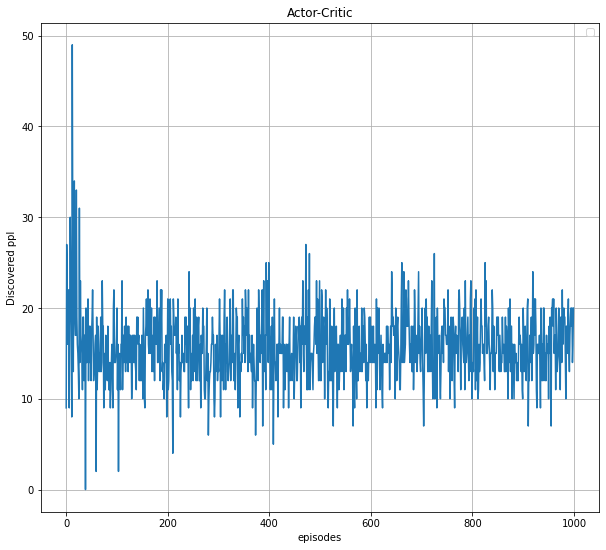

In [176]:
plt.plot(np.arange(episodes), store_captured_ppl)
plt.ylabel('Discovered ppl')
plt.xlabel('episodes')
plt.title('Actor-Critic')
plt.legend()
plt.grid()
plt.show()

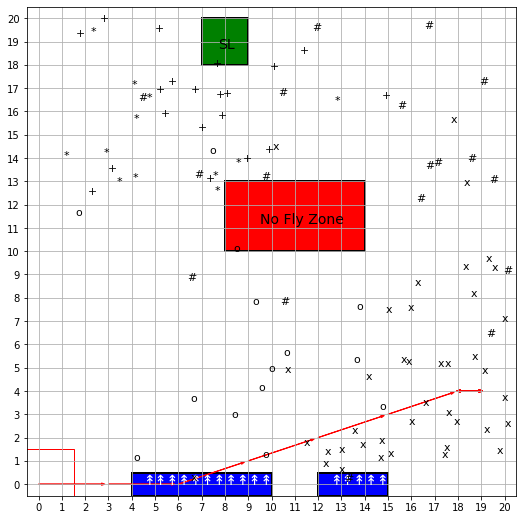

In [177]:
fig=env.render(optimal_path=optimal_path,path_plot=True)
fig